In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import random
from PIL import Image
from IPython.display import display
%matplotlib inline

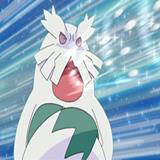

In [35]:
# TEST  VERSION OF PILLOW
with Image.open('Data/Pokemon/Abomasnow/Abomasnow_1.jpg') as im:
    display(im)

# Traverse local system folder tree to save images into folders according to pokemon type
* top of loop commented out To avoid running this script again

df source
https://www.kaggle.com/rounakbanik/pokemon

In [36]:
df = pd.read_csv('Data/pokemon.csv')

In [37]:
df.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

In [38]:
df = df[['name', 'type1', 'type2']]

In [39]:
df.columns

Index(['name', 'type1', 'type2'], dtype='object')

In [40]:
df[:1]

,name,type1,type2
0,Bulbasaur,grass,poison


In [41]:
for index, row in df[:5].iterrows():
    print(f"name: {row[0]}  type1: {row[1]}  type2: {row[2]}")

name: Bulbasaur  type1: grass  type2: poison
name: Ivysaur  type1: grass  type2: poison
name: Venusaur  type1: grass  type2: poison
name: Charmander  type1: fire  type2: nan
name: Charmeleon  type1: fire  type2: nan


In [45]:
path = 'Data/Pokemon'
dest = 'Data/TYPES'

image_names = []

# Traverse local system folder tree to save images into
# type folders: 1 folder per pokemon type
# ====================================================================

for i, (folder, subfolders, filenames) in tqdm(enumerate(os.walk(path))):
    
    if filenames == ['.DS_Store']:
        continue
    if 'Data/Pokemon/POKEMON_TYPES' in folder:
        continue
    
    for file in filenames:
#     iterate over df
        for index, row in df.iterrows():
            name = row[0]
            type1 = row[1]
            type2 = row[2]

            if name.lower() in file.lower():
                src_file = folder + '/' + file
                type1_folder = dest + '/' + type1
                type1_dest = type1_folder + '/' + file

                if not os.path.exists(type1_folder):
                        os.mkdir(type1_folder)

                shutil.copy(src_file, type1_dest)

                if pd.notna(type2):

                    type2_folder = dest + '/' + type2
                    type2_dest = type2_folder + '/' + file

                    if not os.path.exists(type2_folder):
                        os.mkdir(type2_folder)
                    shutil.copy(src_file, type2_folder)
    
#     break   # this line will exit on the first loop. Done for initial testing

948it [28:34,  1.74s/it]


### Split pokemon TYPES folder into train, validation and test (dataset) folders.

In [46]:
import split_folders

In [47]:
input_folder = 'Data/TYPES'
output_folder = 'Data/SplitTypes'

## Split with a ratio.
### To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
### 3 values for training, test and validation i.e, `(.8, .1, .1)`

In [48]:
split_folders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .1, .1))

Copying files: 37027 files [01:07, 545.92 files/s]


(160, 160)


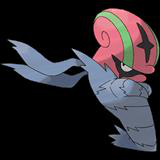

In [49]:
# Inspect the new SplitTypes folder by opening an image

poke = Image.open('Data/SplitTypes/train/bug/Accelgor_1.jpg')

print(poke.size)
display(poke)

In [50]:
r, g, b = poke.getpixel((100, 50))
print(r,g,b)

217 115 136


The pixel at position [100,50] (upper right) of the source image has an rgb value of (217,115,136). This corresponds to <font style="background-color:rgb(217,115,136)">this color </font><br>
### transformations:  image to Tensor


torch.Size([3, 160, 160])


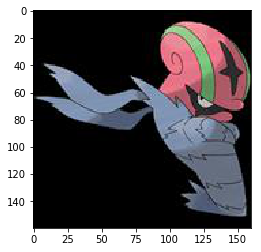

In [56]:
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(poke)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [52]:
im[:,120,130]

tensor([0.3922, 0.4275, 0.4941])

# Building the model process

## Define transforms

In [85]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

## Prepare train and test sets, loaders
Using built-in torchvision dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder'><tt><strong>ImageFolder</strong></tt></a>.

In [86]:
root = 'Data/SplitTypes'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'val'), transform=val_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)
val_loader = DataLoader(test_data, batch_size=10, shuffle=True)


class_names = train_data.classes
class_names_dict = train_data.class_to_idx

In [99]:
print("class_names: ")
print(class_names)
print('=======================')
print(f"class_names_dict: {class_names_dict}")
print('=======================')
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')
print(f'Validation images available:  {len(val_data)}')

class_names: 
['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 'fire', 'flying', 'ghost', 'grass', 'ground', 'ice', 'normal', 'poison', 'psychic', 'rock', 'steel', 'water']
class_names_dict: {'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
Training images available: 29614
Testing images available:  3717
Validation images available:  3696


## Display a batch of images
Show a batch of loaded images to verify that the training loader selects pokemon type images at random.<br>
imshow clips pixel values <0, so the resulting display lacks contrast. Apply inverse transform to the input tensor so  images show their correct colors.

Label: [   13    12     9     6     0     7     8     8    10    14]
Class: poison normal grass fire bug flying ghost ghost ground psychic


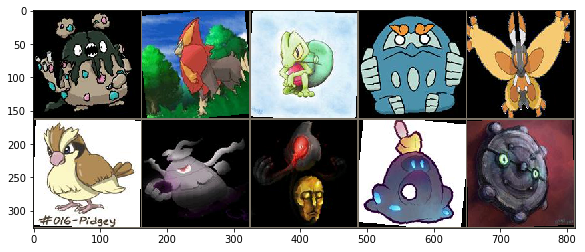

In [91]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

In [64]:
# Pokemon images (160x160)
# params for the first fully connected layer
# (((160-2)/2)-2)/2  = 38.5 --> 38
# 38*38*16

## Define the model

In [92]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 12, 3, 1) # convolutional layers
        self.conv2 = nn.Conv2d(12, 36, 3, 1) # convolutional layers

        self.fc1 = nn.Linear(38*38*36, 180)  #fully connected layers
        self.fc2 = nn.Linear(180, 94)  #fully connected layers
        self.fc3 = nn.Linear(94, 18)  #fully connected layers

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 38*38*36)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

### Instantiate the model, define loss and optimization functions

In [93]:
torch.manual_seed(101)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 36, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=51984, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=94, bias=True)
  (fc3): Linear(in_features=94, out_features=18, bias=True)
)

In [94]:
# Including the bias terms for each layer, the total number of parameters being trained is:

(3*12*3*3) + 12 + (12*36*3*3) + 36 + (51984*180) + 180 + (180*94) + 94 + (94*18) + 18

9380284

### Trainable parameters

In [95]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [96]:
count_parameters(CNNmodel)

     324
      12
    3888
      36
 9357120
     180
   16920
      94
    1692
      18
________
 9380284


In [97]:
len(train_data)

29614

## Train the model

In [53]:
import time
start_time = time.time()

epochs = 50

full_train_set = len(train_data)
full_test_set = len(test_data)

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{full_train_set}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
          
            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

    
seconds_elapsed = time.time() - start_time
minutes_elapsed = seconds_elapsed / 60
hours_elapsed = minutes_elapsed / 60


print(f'\nDuration: {seconds_elapsed:.0f} seconds') # print the time elapsed
print(f'\nDuration: {minutes_elapsed:.2f} minutes') # print the time elapsed
print(f'\nDuration: {hours_elapsed:.2f} hours') # print the time elapsed


epoch:  0  batch:  200 [  2000/35398]  loss: 2.81576252  accuracy:  12.700%
epoch:  0  batch:  400 [  4000/35398]  loss: 2.53294730  accuracy:  15.025%
epoch:  0  batch:  600 [  6000/35398]  loss: 2.69695854  accuracy:  16.767%
epoch:  0  batch:  800 [  8000/35398]  loss: 2.85925531  accuracy:  17.375%
epoch:  0  batch: 1000 [ 10000/35398]  loss: 2.50256777  accuracy:  18.070%
epoch:  0  batch: 1200 [ 12000/35398]  loss: 2.54349756  accuracy:  18.233%
epoch:  0  batch: 1400 [ 14000/35398]  loss: 2.66416550  accuracy:  18.629%
epoch:  0  batch: 1600 [ 16000/35398]  loss: 2.54376984  accuracy:  18.788%
epoch:  0  batch: 1800 [ 18000/35398]  loss: 2.37616110  accuracy:  18.944%
epoch:  0  batch: 2000 [ 20000/35398]  loss: 2.41060686  accuracy:  19.040%
epoch:  0  batch: 2200 [ 22000/35398]  loss: 2.51347017  accuracy:  19.109%
epoch:  0  batch: 2400 [ 24000/35398]  loss: 2.46918106  accuracy:  19.233%
epoch:  0  batch: 2600 [ 26000/35398]  loss: 2.52334452  accuracy:  19.385%
epoch:  0  b

In [503]:
print(f"Total Training Time : {minutes/60:.2f} Hours")

Total Training Time : 9.82 Hours


## Save the trained model

In [73]:
torch.save(CNNmodel.state_dict(), 'Pokemon50eCNNModel.pt')

In [98]:
# Instantiate the model and load saved parameters

moe_model = ConvolutionalNetwork()
moe_model.load_state_dict(torch.load('Pokemon50eCNNModel.pt'))
moe_model.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(12, 36, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=51984, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=94, bias=True)
  (fc3): Linear(in_features=94, out_features=18, bias=True)
)

In [105]:
# Evaluate the saved model against the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = moe_model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'\nTest set accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')


Test set accuracy: 1738/3717 =  46.758%


In [104]:
# Evaluate the saved model against the VALIDATION set

val_load_all = DataLoader(val_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_val, y_val in val_load_all:
        y_value = moe_model(X_val)
        predicted = torch.max(y_value,1)[1]
        correct += (predicted == y_val).sum()
        
print(f'\nValidation set accuracy: {correct.item()}/{len(val_data)} = {correct.item()*100/(len(val_data)):7.3f}%')


Validation set accuracy: 1750/3696 =  47.348%


## Evaluate model performance

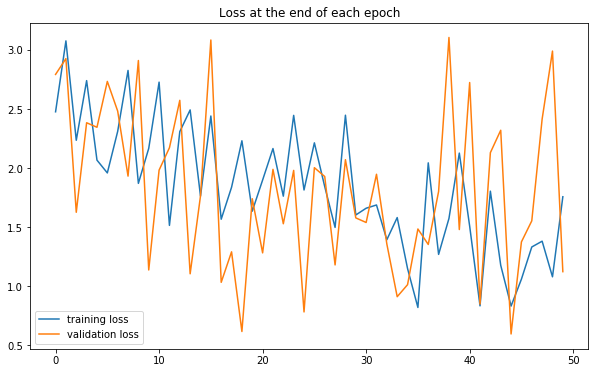

In [351]:
plt.figure(figsize = (10,6))

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

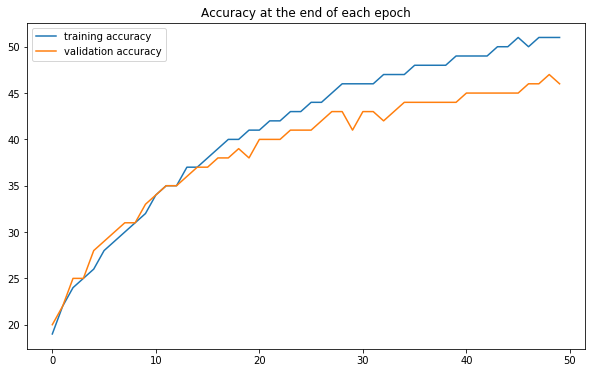

In [352]:
plt.figure(figsize = (10,6))

plt.plot([100*t/len(train_data) for t in train_correct], label='training accuracy')
plt.plot([100*t/len(test_data) for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Confusion matrix
run the entire test set through the model in order to map predictions against the truth values<br>


# RUN the saved model against the TEST SET

In [121]:
# Create a loader for the entire test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

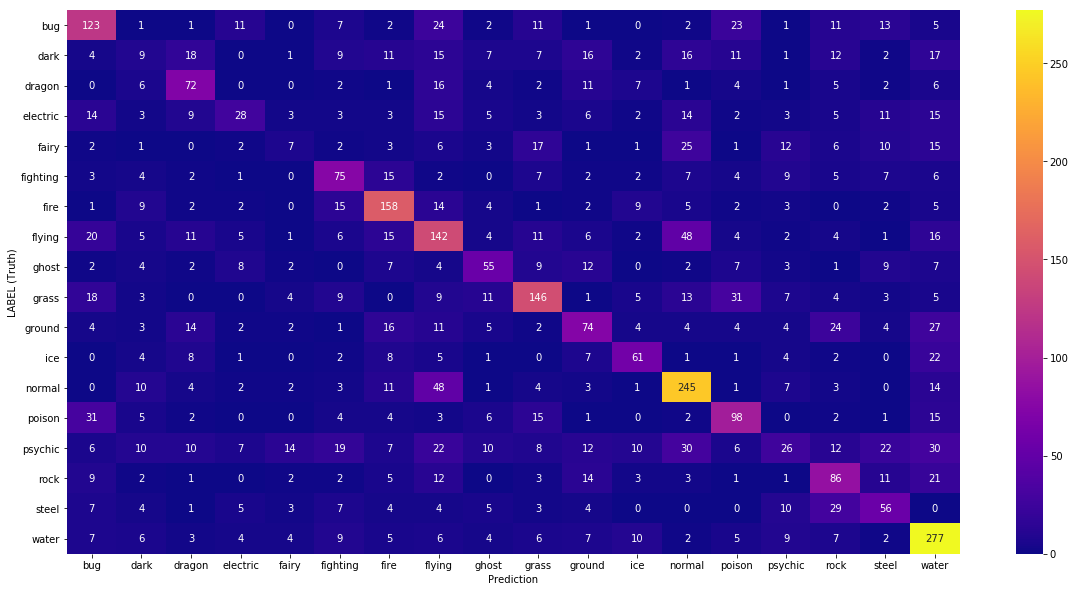

In [124]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = moe_model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (20,10))
# sn.heatmap(df_cm, annot=True, fmt="d", cmap='PuRd')
sn.heatmap(df_cm, annot=True, fmt="d", cmap='plasma')


plt.xlabel("Prediction")
plt.ylabel("LABEL (Truth)")
plt.show();

# RUN the saved model against the VALIDATION SET


In [110]:
# Create a loader for the entire validation set
val_load_all = DataLoader(val_data, batch_size=10000, shuffle=False)

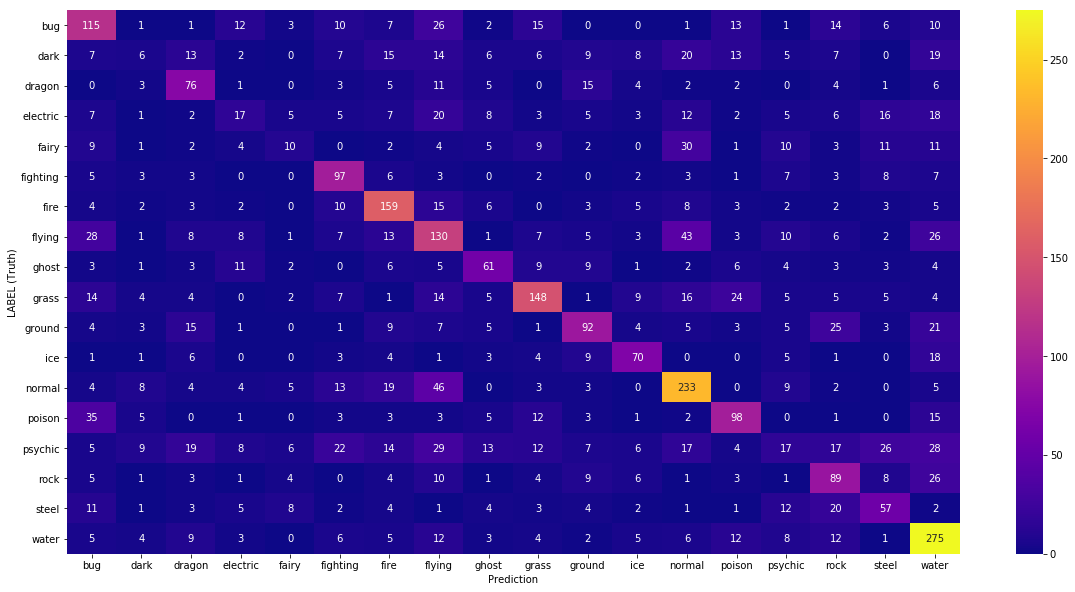

In [125]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in val_load_all:
        y_val = moe_model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (20,10))
# sn.heatmap(df_cm, annot=True, fmt="d", cmap='PuRd') YlGnBu
sn.heatmap(df_cm, annot=True, fmt="d", cmap='plasma')
# sn.heatmap(df_cm, annot=True, fmt="d", cmap='YlGnBu') 



plt.xlabel("Prediction")
plt.ylabel("LABEL (Truth)")
plt.show();

## Examine the misses
Track the index positions of "missed" predictions, and extract the corresponding image and label. Done in batches to save screen space.

In [499]:
len(predicted.view(-1))

3717

In [228]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

1979

In [229]:
# Display the first 8 index positions
misses[:8]

array([    0,     2,     4,     7,     8,     9,    10,    11])

In [230]:
# Set up an iterator to feed batched rows
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




Index: [     654      655      657      658      659      660      661      662]
Label: [       3        3        3        3        3        3        3        3]
Class:    electric   electric   electric   electric   electric   electric   electric   electric  

Guess: [       0        0        7       15       12       15        2       15]
Class:    bug   bug   flying   rock   normal   rock   dragon   rock  


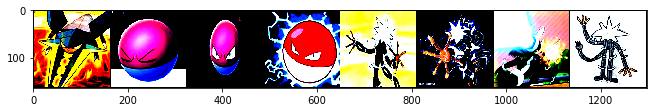

In [317]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:8}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
guess = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("\n\nIndex:", nextrow)
print("Label:", lbls) 
print("Class:   ", *np.array([class_names[i]+ '  ' for i in lbls]))
print()
print("Guess:", guess)
print("Class:   ", *np.array([class_names[i]+ '  ' for i in guess]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(11,7))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [81]:
print(test_correct)
print(f'\nTest accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(775), tensor(836), tensor(932), tensor(959), tensor(1056), tensor(1113), tensor(1127), tensor(1181), tensor(1165), tensor(1243), tensor(1270), tensor(1310), tensor(1329), tensor(1340), tensor(1382), tensor(1394), tensor(1442), tensor(1438), tensor(1452), tensor(1432), tensor(1497), tensor(1501), tensor(1515), tensor(1534), tensor(1542), tensor(1551), tensor(1584), tensor(1606), tensor(1599), tensor(1546), tensor(1624), tensor(1603), tensor(1575), tensor(1632), tensor(1655), tensor(1641), tensor(1659), tensor(1670), tensor(1660), tensor(1672), tensor(1690), tensor(1678), tensor(1706), tensor(1705), tensor(1697), tensor(1707), tensor(1717), tensor(1739), tensor(1751), tensor(1738)]

Test accuracy: 46.758%


# Run a new image through the model
Pass a single image through the model to obtain a prediction.<br>

In [169]:
test_data

Dataset ImageFolder
    Number of datapoints: 3717
    Root Location: Data/SplitTypes/test
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [170]:
train_data

Dataset ImageFolder
    Number of datapoints: 35398
    Root Location: Data/SplitTypes/train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [128]:
## Dictionary that maps the name of the class to the model output
class_names_dict

{'bug': 0,
 'dark': 1,
 'dragon': 2,
 'electric': 3,
 'fairy': 4,
 'fighting': 5,
 'fire': 6,
 'flying': 7,
 'ghost': 8,
 'grass': 9,
 'ground': 10,
 'ice': 11,
 'normal': 12,
 'poison': 13,
 'psychic': 14,
 'rock': 15,
 'steel': 16,
 'water': 17}

In [129]:
# Choose a number between 0 and 3716 --> ( num of images in test_data)
x = random.randint(0, len(test_data))
x

2754


Actual Class: ghost



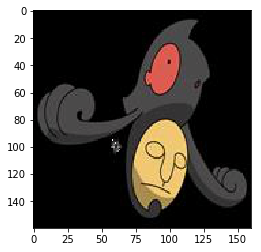

In [506]:
image_tensor = test_data[x][0]
x_class = test_data[x][1]
real_class = [item for item in class_names_dict if class_names_dict[item]== x_class][0]
im = inv_normalize(image_tensor)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
print(f"\nActual Class: {real_class}\n")

In [507]:
image_tensor.shape

torch.Size([3, 160, 160])

In [509]:
# CNN Model Prediction:
CNNmodel.eval()
with torch.no_grad():
    new_pred = CNNmodel(image_tensor.view(1,3,160,160)).argmax()
print(f'\nPredicted Class: {new_pred.item()} {class_names[new_pred.item()]}\n')


Predicted Class: 8 ghost



# Test the saved model: Model Prediction(MoeNet):

## Select an Image from the test set to run through the Model

In [511]:
# Choose a number between 0 and 3716 --> ( num of images in test_data)
x = random.randint(0, len(test_data))
x

1121

### Display the image


Actual Class: fire



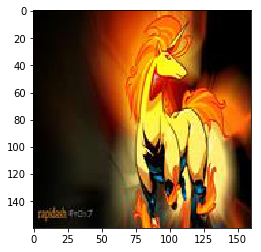

In [512]:
image_tensor = test_data[x][0]
x_class = test_data[x][1]
real_class = [item for item in class_names_dict if class_names_dict[item]== x_class][0]
im = inv_normalize(image_tensor)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
print(f"\nActual Class: {real_class}\n")

## Run Image through the model

In [513]:
moe_model.eval()
with torch.no_grad():
    new_pred = moe_model(image_tensor.view(1,3,160,160)).argmax()
print(f'\nPredicted Class: {new_pred.item()} {class_names[new_pred.item()]}\n')


Predicted Class: 6 fire



In [74]:
# 3 epoch batch max 800/300

# self.conv1 = nn.Conv2d(3, 12, 3, 1)
# self.conv2 = nn.Conv2d(12, 36, 3, 1)

# self.fc1 = nn.Linear(38*38*36, 180)
# self.fc2 = nn.Linear(180, 94)
# self.fc3 = nn.Linear(94, 18)

# epochs: 3,  batch:  800 [  8000/8000]  loss: 2.80495930  accuracy:  20.988%
# Duration: 6.09 minutes

# full image set: Duration: 26.01 minutes:
# epoch:  2  batch: 3400 [ 34000/8000]  loss: 2.97221971  accuracy:  26.568%

In [ ]:
# 800 batch max 3 epoch:

# self.conv1 = nn.Conv2d(3, 36, 3, 1)
# self.conv2 = nn.Conv2d(36, 108, 3, 1)
# self.fc1 = nn.Linear(38*38*108, 240)
# self.fc2 = nn.Linear(240, 140)
# self.fc3 = nn.Linear(140, 18)
# epoch:  2  batch:  800 [  8000/8000]  loss: 2.59948874  accuracy:  18.363%
# Duration: 19.19 minutes

In [88]:
# epoch: 3
# max batch 8000
# transforms.Resize(224)
# transforms.CenterCrop(224),
# self.conv1 = nn.Conv2d(3, 6, 3, 1)
# self.conv2 = nn.Conv2d(6, 16, 3, 1)
# self.fc1 = nn.Linear(54*54*16, 120)
# self.fc2 = nn.Linear(120, 84)
# self.fc3 = nn.Linear(84, 18)
# epoch:  2  batch:  800 [  8000/8000]  loss: 2.78099370  accuracy:  20.538%
# Duration: 5.70 minutes